In [11]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [12]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [13]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [ ]:
def compute_rsrs_base(df, window_N=16):
    """
    计算基础RSRS指标（斜率和决定系数）
    """
    high = df['high'].values
    low = df['low'].values
    beta = np.full(len(df), np.nan)
    r_squared = np.full(len(df), np.nan)
    
    # 使用向量化操作提高效率
    for i in range(window_N-1, len(df)):
        start_idx = i - window_N + 1
        end_idx = i + 1
        
        # 提取窗口数据
        X = low[start_idx:end_idx]
        y = high[start_idx:end_idx]
        
        # 添加常数项
        X = np.column_stack((np.ones(window_N), X))
        
        # 计算回归系数
        XtX = X.T @ X
        if np.linalg.det(XtX) < 1e-5:  # 避免奇异矩阵
            continue
            
        beta_val = np.linalg.inv(XtX) @ X.T @ y
        beta[i] = beta_val[1]
        
        # 计算R-squared
        y_pred = X @ beta_val
        ss_total = np.sum((y - np.mean(y))**2)
        ss_res = np.sum((y - y_pred)**2)
        r_squared[i] = 1 - (ss_res / ss_total) if ss_total > 0 else 0
    
    return pd.Series(beta, index=df.index), pd.Series(r_squared, index=df.index)

def rsrs_basic_factor(df, N=16):
    """
    基础RSRS因子 - 回归斜率
    """
    beta, _ = compute_rsrs_base(df, N)
    return beta.fillna(0)

def rsrs_zscore_factor(df, N=16, M=300):
    """
    标准分RSRS因子
    """
    beta, _ = compute_rsrs_base(df, N)
    rolling_mean = beta.rolling(M).mean()
    rolling_std = beta.rolling(M).std().replace(0, 1e-5)  # 避免除以零
    zscore = (beta - rolling_mean) / rolling_std
    return zscore.fillna(0)

def rsrs_zscore_r2_factor(df, N=16, M=300):
    """
    修正标准分RSRS因子
    """
    beta, r2 = compute_rsrs_base(df, N)
    rolling_mean = beta.rolling(M).mean()
    rolling_std = beta.rolling(M).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    return (zscore * r2).fillna(0)

def rsrs_zscore_positive_factor(df, N=16, M=300):
    """
    右偏标准分RSRS因子
    """
    beta, r2 = compute_rsrs_base(df, N)
    rolling_mean = beta.rolling(M).mean()
    rolling_std = beta.rolling(M).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    return (zscore * r2 * beta).fillna(0)

def rsrs_volume_weighted_factor(df, N=16):
    """
    成交量加权RSRS因子
    """
    high = df['high'].values
    low = df['low'].values
    volume = df['volume'].values
    beta = np.full(len(df), np.nan)
    
    for i in range(N-1, len(df)):
        start_idx = i - N + 1
        end_idx = i + 1
        
        # 提取窗口数据
        X = low[start_idx:end_idx]
        y = high[start_idx:end_idx]
        weights = volume[start_idx:end_idx]
        
        # 添加常数项
        X = np.column_stack((np.ones(N), X))
        
        # 加权最小二乘
        W = np.diag(weights)
        XtWX = X.T @ W @ X
        
        if np.linalg.det(XtWX) < 1e-5:
            continue
            
        beta_val = np.linalg.inv(XtWX) @ X.T @ W @ y
        beta[i] = beta_val[1]
    
    return pd.Series(beta, index=df.index).fillna(0)

def rsrs_combined_factor(df, N=16, M=300):
    """
    组合RSRS因子 - 结合四种RSRS变体
    """
    # 计算各因子
    basic = rsrs_basic_factor(df, N)
    zscore = rsrs_zscore_factor(df, N, M)
    zscore_r2 = rsrs_zscore_r2_factor(df, N, M)
    zscore_positive = rsrs_zscore_positive_factor(df, N, M)
    
    # 标准化因子
    factors = pd.DataFrame({
        'basic': basic,
        'zscore': zscore,
        'zscore_r2': zscore_r2,
        'zscore_positive': zscore_positive
    })
    
    # 归一化处理
    normalized = factors.apply(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x - x.mean())
    
    # 简单加权平均
    weights = np.array([0.2, 0.3, 0.3, 0.2])
    combined = normalized.dot(weights)
    
    # 最终归一化
    abs_mean = combined.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return combined / abs_mean

def rsrs_with_volume_factor(df, N=16, M=300):
    """
    RSRS与成交量压力组合因子
    """
    # RSRS因子
    rsrs_factor = rsrs_zscore_r2_factor(df, N, M)
    
    # 成交量压力因子
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan)
    buy_pressure = buy_pressure.fillna(0.5)  # 中性值
    
    # 标准化
    rsrs_norm = (rsrs_factor - rsrs_factor.mean()) / rsrs_factor.std()
    pressure_norm = (buy_pressure - buy_pressure.mean()) / buy_pressure.std()
    
    # 组合
    combined = rsrs_norm * 0.7 + pressure_norm * 0.3
    
    # 归一化
    abs_mean = combined.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return combined / abs_mean

def optimize_weights(df, factors, target):
    """
    优化因子权重
    """
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    
    # 移除无效数据
    valid_rows = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_rows]
    y = y.loc[valid_rows]
    
    if len(X) == 0:
        return np.ones(len(factors)) / len(factors)  # 默认等权重
    
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

def improved_factor(df):
    """
    改进的组合因子 - 包含多种RSRS变体和成交量信息
    """
    # 计算RSRS因子
    rsrs_basic = rsrs_basic_factor(df)
    rsrs_z = rsrs_zscore_factor(df)
    rsrs_zr2 = rsrs_zscore_r2_factor(df)
    rsrs_zpos = rsrs_zscore_positive_factor(df)
    rsrs_vol = rsrs_volume_weighted_factor(df)
    
    # 成交量压力因子
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan)
    buy_pressure = buy_pressure.fillna(0.5)
    
    # 标准化所有因子
    factors_to_standardize = {
        'rsrs_basic': rsrs_basic,
        'rsrs_z': rsrs_z,
        'rsrs_zr2': rsrs_zr2,
        'rsrs_zpos': rsrs_zpos,
        'rsrs_vol': rsrs_vol,
        'buy_pressure': buy_pressure
    }
    
    standardized_factors = {}
    for name, factor_series in factors_to_standardize.items():
        mean_val = factor_series.mean()
        std_val = factor_series.std()
        if std_val < 1e-5:
            standardized_factor = factor_series - mean_val
        else:
            standardized_factor = (factor_series - mean_val) / std_val
        standardized_factors[name] = standardized_factor.fillna(0)
    
    # 定义因子字典和目标函数
    factors_dict = {
        'rsrs_basic': lambda df: standardized_factors['rsrs_basic'],
        'rsrs_z': lambda df: standardized_factors['rsrs_z'],
        'rsrs_zr2': lambda df: standardized_factors['rsrs_zr2'],
        'rsrs_zpos': lambda df: standardized_factors['rsrs_zpos'],
        'rsrs_vol': lambda df: standardized_factors['rsrs_vol'],
        'buy_pressure': lambda df: standardized_factors['buy_pressure']
    }
    
    # 目标函数：未来10期收益率
    target_func = lambda df: df['close'].pct_change(10).shift(-10)
    
    # 优化权重
    try:
        weights = optimize_weights(df, factors_dict, target_func)
    except Exception as e:
        print(f"权重优化失败: {e}")
        weights = np.ones(len(factors_dict)) / len(factors_dict)  # 默认等权重
    
    # 组合因子
    combined_factor = sum(weight * factor(df) for weight, factor in zip(weights, factors_dict.values()))
    
    # 最终归一化处理
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    normalized_factor = combined_factor / abs_mean
    
    return normalized_factor

In [15]:
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_rsrs_factor'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.012753
   Rank_IC (Spearman): 0.019826
📊 信息比率:
   IR: -0.044218
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130650
   因子列: improved_rsrs_factor
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


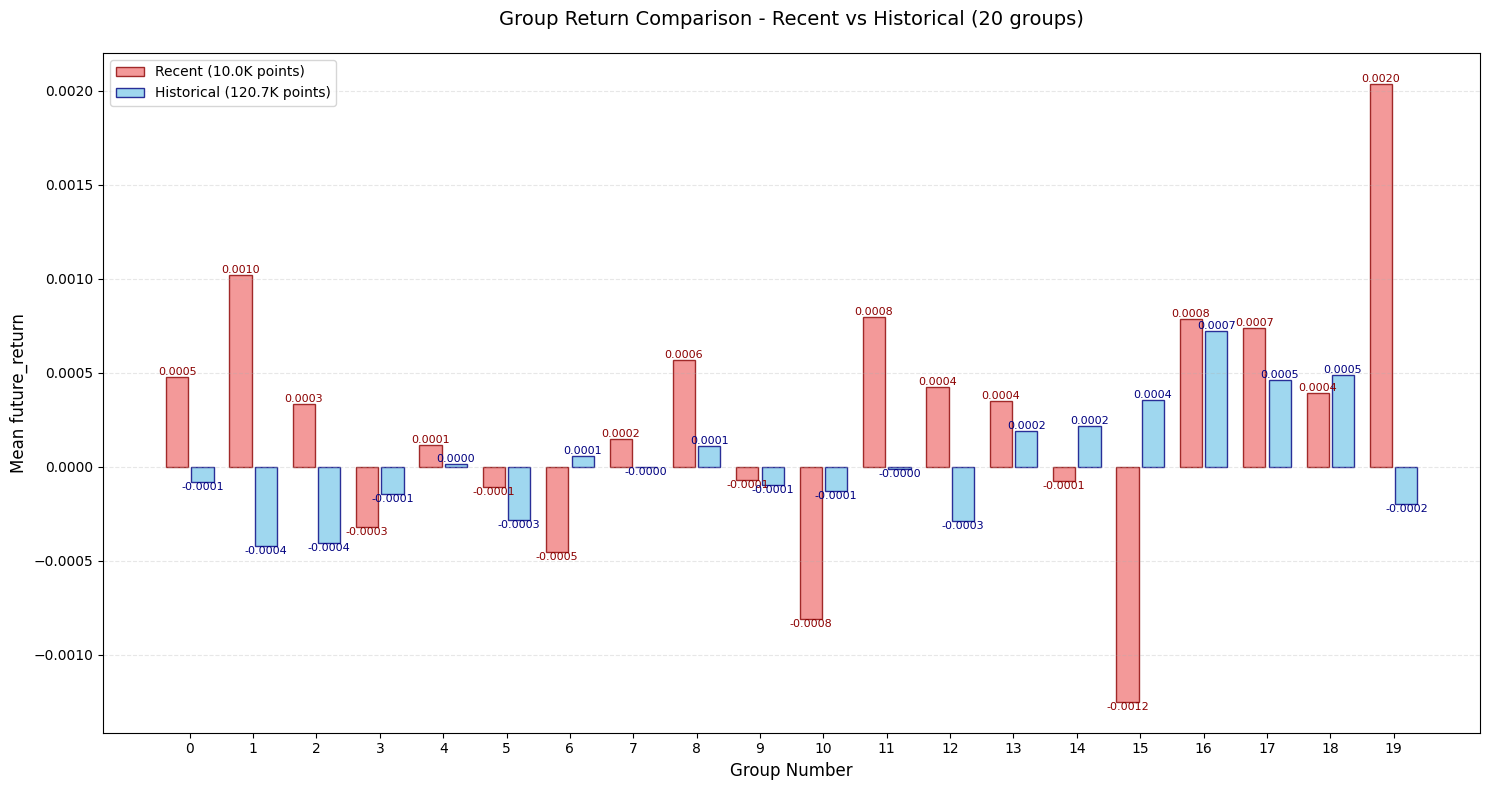

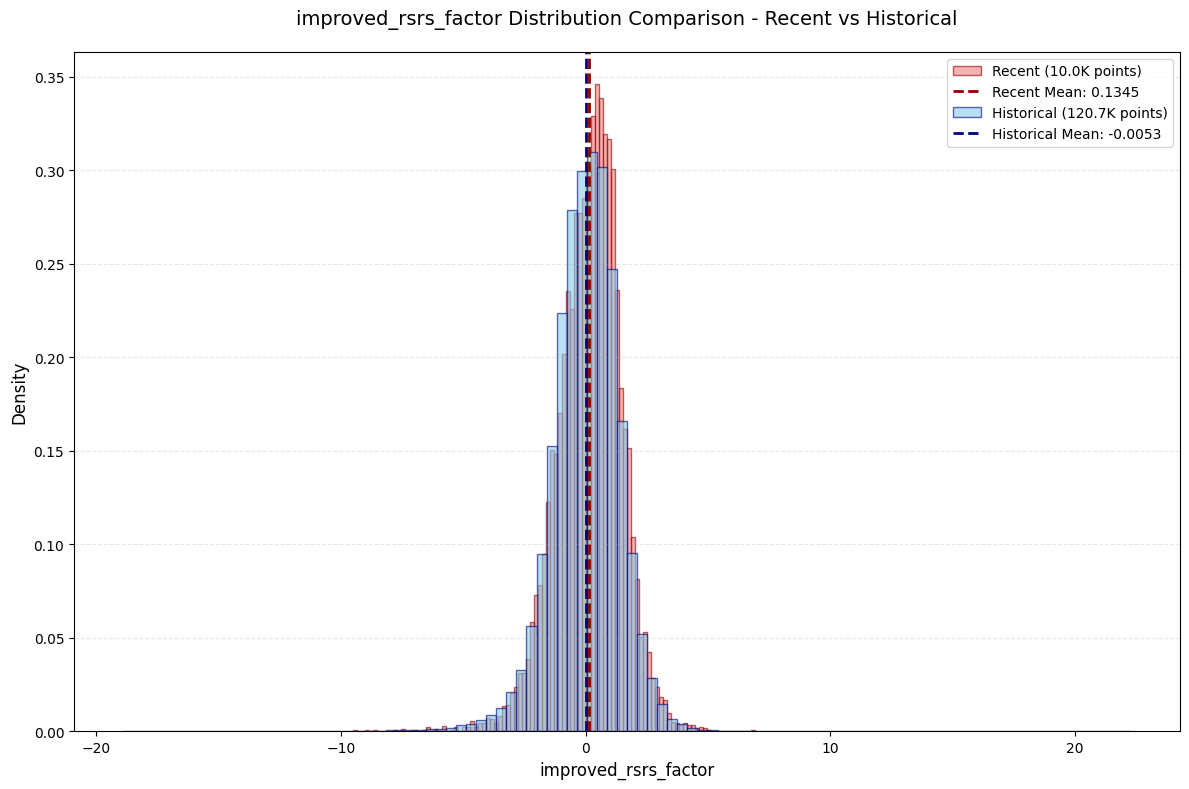

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [16]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)